In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from astropy.constants import G, c, M_sun , hbar
import astropy.units as u

plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 150,                   
    "grid.alpha": 0.4,                    
})


In [89]:
# Units conversion
hc = 197.3269804 # MeV fm
B = 145 ** 4 # MeV^4

M_p = 1.2209e22  # MeV
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30

factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
factor_M_to_Solar = (M_p **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
factor_P_to_MeV4 = 4 * B
factor_P_to_Mevfm3 = factor_P_to_MeV4 / hc**3

# Ordinary Matter

Equation of state digitilized from Mikel's Master Thesis

In [7]:
exponents_EoSI = pd.read_csv('../Data/EoS1_Mikel.csv') # This are exponents from the log scale

grid_EOSI_e_phys = 10 ** exponents_EoSI['x'] # MeV / fm3
grid_EOSI_p_phys = 10 ** exponents_EoSI[' y']

grid_EOSI_e = grid_EOSI_e_phys * hc**3 / (4 * B) # Dimensionless energy density
grid_EOSI_p = grid_EOSI_p_phys * hc**3 / (4 * B) # Dimensionless pressure

exponents_EoSII = pd.read_csv('../Data/EoSII_Mikel.csv') # This are exponents from the log scale

grid_EOSII_e_phys = 10 ** exponents_EoSII['x'] # MeV / fm3
grid_EOSII_p_phys = 10 ** exponents_EoSII[' y']

grid_EOSII_e = grid_EOSII_e_phys * hc**3 / (4 * B) # Dimensionless energy density
grid_EOSII_p = grid_EOSII_p_phys * hc**3 / (4 * B) # Dimensionless pressure



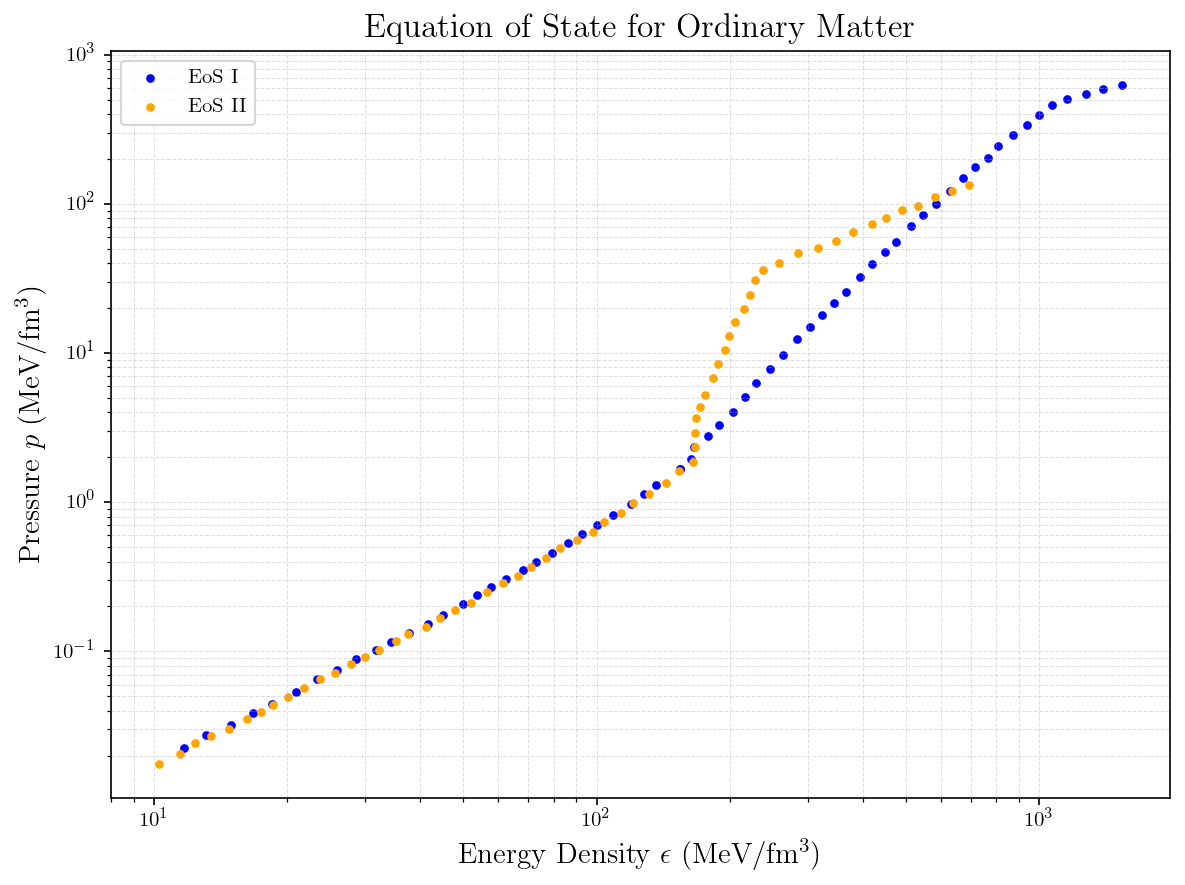

In [10]:
# plot
plt.figure(figsize=(8, 6))
plt.scatter(grid_EOSI_e_phys, grid_EOSI_p_phys, label='EoS I', color='blue', s=10)
plt.scatter(grid_EOSII_e_phys, grid_EOSII_p_phys, label='EoS II', color='orange', s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Energy Density $\epsilon$ (MeV/fm$^3$)', fontsize=14)
plt.ylabel(r'Pressure $p$ (MeV/fm$^3$)', fontsize=14)
plt.title('Equation of State for Ordinary Matter', fontsize=16)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()

plt.show()

In [13]:
#print maximums and minimums of the curves
print('EoS I:')
print(f'Maximum Pressure: {max(grid_EOSI_p)}')
print(f'Minimum Pressure: {min(grid_EOSI_p)}')
print()
print(f'Maximum Energy Density: {max(grid_EOSI_e)}')
print(f'Minimum Energy Density: {min(grid_EOSI_e)}')
print('----------------------------------')
print()
print('EoS II:')
print(f'Maximum Pressure: {max(grid_EOSII_p)}')
print(f'Minimum Pressure: {min(grid_EOSII_p)}')
print()
print(f'Maximum Energy Density: {max(grid_EOSII_e)}')
print(f'Minimum Energy Density: {min(grid_EOSII_e)}')




EoS I:
Maximum Pressure: 2.7382334062231157
Minimum Pressure: 9.80362576218867e-05

Maximum Energy Density: 6.6853844381419085
Minimum Energy Density: 0.05079062419658112
----------------------------------

EoS II:
Maximum Pressure: 0.5841889201140258
Minimum Pressure: 7.673987740207549e-05

Maximum Energy Density: 3.012279832936865
Minimum Energy Density: 0.0445726881282077


In [32]:

def solve_TOV(central_energy, x0, grid_p_eos, grid_e_eos):

    def ode_TOV(r, x):
        p, M = x

        e = np.interp(p, grid_p_eos, grid_e_eos)

        if r < 1e-8:
            dpdr = 0.0
            dMdr = 4*np.pi*r**2*e
            return [dpdr, dMdr]

        term1 = (e + p)
        term2 = (M + 4*np.pi*r**3*p)
        term3 = r * (r - 2*M)

        dpdr = - term1 * term2 / term3
        dMdr =  4*np.pi * r**2 * e

        return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 1e20),     # integrate up to r=1e5  corresponds to 
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10, #tolerance error
        max_step=0.1
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]


    if P_surface > 1e-10 :
        print("Final pressure is far from 0:", P_surface )
    
    return R_surface, M_surface


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


list_R_EOSI = []
list_M_EOSI = []
list_R_EOSII = []
list_M_EOSII = []

list_p_central_conditions = np.logspace(-5, 1, 50) 
list_e_central_conditions_EOSI = np.interp(list_p_central_conditions, grid_EOSI_p,  grid_EOSI_e) 
list_e_central_conditions_EOSII = np.interp(list_p_central_conditions, grid_EOSII_p,  grid_EOSII_e) 

for p_central, e_central_EOSI, e_central_EOSII in zip(list_p_central_conditions, list_e_central_conditions_EOSI, list_e_central_conditions_EOSII):
    r0 = 1e-6
    central_mass_EOSI = (4/3) * np.pi * (r0**3) * e_central_EOSI
    x0_EOSI = [p_central, central_mass_EOSI]

    R_surface_EOSI, M_surface_EOSI = solve_TOV(e_central_EOSI, x0_EOSI,  grid_EOSI_p, grid_EOSI_e)

    list_R_EOSI.append(R_surface_EOSI)
    list_M_EOSI.append(M_surface_EOSI)

    central_mass_EOSII = (4/3) * np.pi * (r0**3) * e_central_EOSII
    x0_EOSII = [p_central, central_mass_EOSII]

    R_surface_EOSII, M_surface_EOSII = solve_TOV(e_central_EOSII, x0_EOSII,  grid_EOSII_p, grid_EOSII_e)

    list_R_EOSII.append(R_surface_EOSII)
    list_M_EOSII.append(M_surface_EOSII)




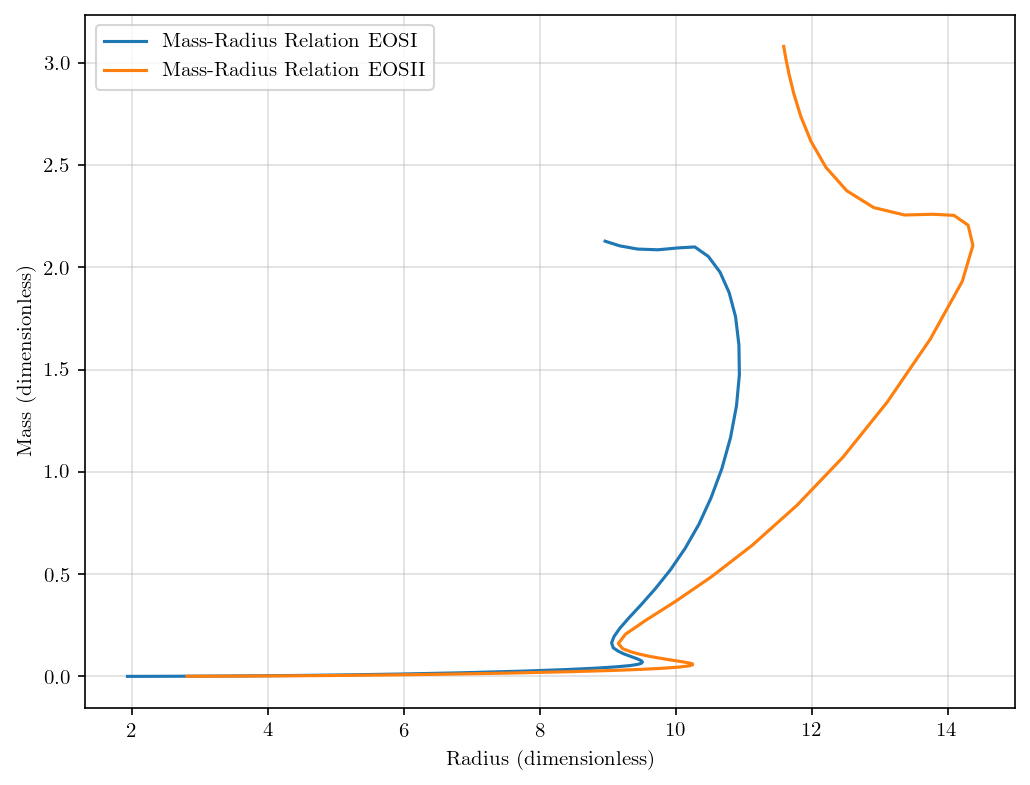

In [34]:
plt.figure(figsize=(8,6), dpi=150)

plt.plot(np.array(list_R_EOSI) * factor_R_to_km, np.array(list_M_EOSI) * factor_M_to_Solar, label='Mass-Radius Relation EOSI')
plt.plot(np.array(list_R_EOSII) * factor_R_to_km, np.array(list_M_EOSII)* factor_M_to_Solar, label='Mass-Radius Relation EOSII')


plt.xlabel('Radius (dimensionless)')
plt.ylabel('Mass (dimensionless)')
plt.grid()
plt.legend()
plt.show()



This results are different from the ones i obtained in the past. It is clearly not a problem of the solver. Because i didnt change anything from the previous code> 5_Bosonic_Matter. Hence must be from the interpolation, or the EoS itself.

Steps taken:
- 1. Create a denser grid
- 2. Ensure that the IC are well inside the grid. Not using 5% of the grid limits and selecting a 20% of the grid data points

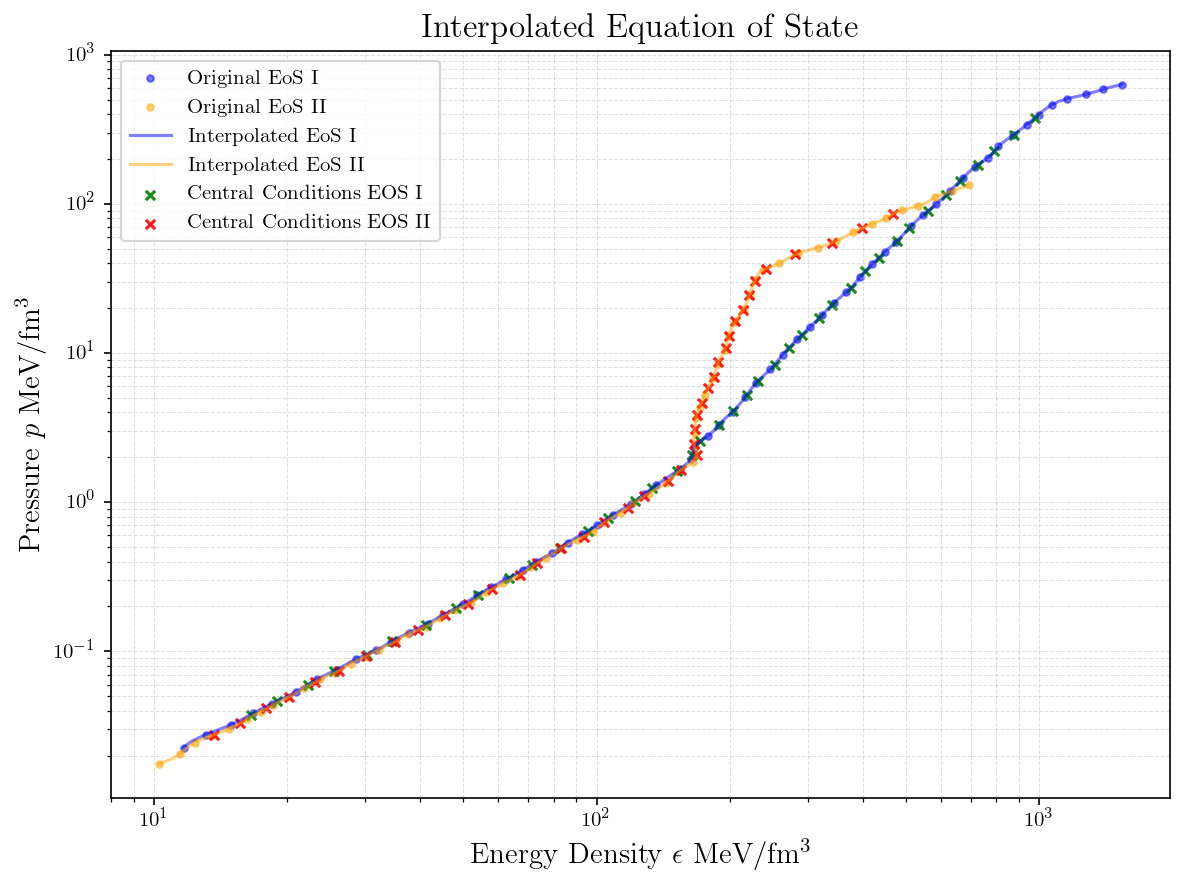

In [90]:
# I will use interpolation to create a denser grid

exponents_EoSI = pd.read_csv('../Data/EoS1_Mikel.csv') # This are exponents from the log scale
exponents_EoSI = exponents_EoSI.sort_values(by=' y').drop_duplicates(subset=[' y']) # necessary to avoid duplicate pressures that cause problems in interpolation

grid_EOSI_e_phys = 10 ** exponents_EoSI['x'] # MeV / fm3
grid_EOSI_p_phys = 10 ** exponents_EoSI[' y']

grid_EOSI_e = grid_EOSI_e_phys * hc**3 / (4 * B) # Dimensionless energy density
grid_EOSI_p = grid_EOSI_p_phys * hc**3 / (4 * B) # Dimensionless pressure

exponents_EoSII = pd.read_csv('../Data/EoSII_Mikel.csv') # This are exponents from the log scale
exponents_EoSII = exponents_EoSII.sort_values(by=' y').drop_duplicates(subset=[' y'])

grid_EOSII_e_phys = 10 ** exponents_EoSII['x'] # MeV / fm3
grid_EOSII_p_phys = 10 ** exponents_EoSII[' y']

grid_EOSII_e = grid_EOSII_e_phys * hc**3 / (4 * B) # Dimensionless energy density
grid_EOSII_p = grid_EOSII_p_phys * hc**3 / (4 * B) # Dimensionless pressure


from scipy.interpolate import interp1d

interp_EOSI = interp1d(grid_EOSI_p, grid_EOSI_e, kind='cubic', fill_value="extrapolate")
interp_EOSII = interp1d(grid_EOSII_p, grid_EOSII_e, kind='cubic', fill_value="extrapolate")


new_pressures_EOSI = np.logspace(np.log10(min(grid_EOSI_p)), np.log10(max(grid_EOSI_p)), 200)
new_pressures_EOSII = np.logspace(np.log10(min(grid_EOSII_p)), np.log10(max(grid_EOSII_p)), 200)

new_energy_EOSI = interp_EOSI(new_pressures_EOSI)
new_energy_EOSII = interp_EOSII(new_pressures_EOSII)


# Create Initial conditions: 


# Create initial coditions for TOV loop

# Remove the extremums  5%
total_len_EOSI = len(new_pressures_EOSI)
offset_EOSI = int(total_len_EOSI * 0.05) 

total_len_EOSII = len(new_pressures_EOSII)
offset_EOSII = int(total_len_EOSII * 0.05) 


# Discard top 5% and bottom 5%)

trimmed_p_EOSI = new_pressures_EOSI[offset_EOSI:-offset_EOSI]
trimmed_e_I = new_energy_EOSI[offset_EOSI:-offset_EOSI]

trimmed_p_EOSII = new_pressures_EOSII[offset_EOSII:-offset_EOSII]
trimmed_e_II = new_energy_EOSII[offset_EOSII:-offset_EOSII]

# Pick 20% indices from this trimmed range
num_samples_EOSI = int(total_len_EOSI * 0.20)
indices_EOSI = np.linspace(0, len(trimmed_p_EOSI) - 1, num_samples_EOSI, dtype=int)

num_samples_EOSII = int(total_len_EOSII * 0.20)
indices_EOSII = np.linspace(0, len(trimmed_p_EOSII) - 1, num_samples_EOSII, dtype=int)

#  Final lists
list_p_central_conditions_EOSI = trimmed_p_EOSI[indices_EOSI]
list_p_central_conditions_EOSII = trimmed_p_EOSII[indices_EOSII]
list_e_central_conditions_EOSI = trimmed_e_I[indices_EOSI]
list_e_central_conditions_EOSII = trimmed_e_II[indices_EOSII]



plt.figure(figsize=(8, 6))


plt.scatter(grid_EOSI_e * factor_P_to_Mevfm3  , grid_EOSI_p* factor_P_to_Mevfm3, label='Original EoS I', color='blue', s=10, alpha=0.5)
plt.scatter(grid_EOSII_e* factor_P_to_Mevfm3, grid_EOSII_p* factor_P_to_Mevfm3, label='Original EoS II', color='orange', s=10, alpha=0.5)

plt.plot(new_energy_EOSI* factor_P_to_Mevfm3, new_pressures_EOSI* factor_P_to_Mevfm3, label='Interpolated EoS I', color='blue', linestyle='-', alpha=0.5)
plt.plot(new_energy_EOSII* factor_P_to_Mevfm3, new_pressures_EOSII* factor_P_to_Mevfm3, label='Interpolated EoS II', color='orange', linestyle='-', alpha=0.5)

plt.scatter(list_e_central_conditions_EOSI* factor_P_to_Mevfm3, list_p_central_conditions_EOSI* factor_P_to_Mevfm3, label='Central Conditions EOS I', color='green', s=20, marker='x', alpha=0.9)
plt.scatter(list_e_central_conditions_EOSII* factor_P_to_Mevfm3, list_p_central_conditions_EOSII* factor_P_to_Mevfm3, label='Central Conditions EOS II ', color='red', s=20, marker='x', alpha=0.9)

plt.xscale('log')
plt.yscale('log')


plt.xlabel(r'Energy Density $\epsilon$ MeV/fm$^3$', fontsize=14)
plt.ylabel(r'Pressure $p$  MeV/fm$^3$', fontsize=14)

plt.title('Interpolated Equation of State', fontsize=16)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [80]:
list_R_EOSI = []
list_M_EOSI = []
list_R_EOSII = []
list_M_EOSII = []


for p_central_EOSI, p_central_EOSII, e_central_EOSI, e_central_EOSII in zip(list_p_central_conditions_EOSI, list_p_central_conditions_EOSII, list_e_central_conditions_EOSI, list_e_central_conditions_EOSII):
    r0 = 1e-6
    central_mass_EOSI = (4/3) * np.pi * (r0**3) * e_central_EOSI
    x0_EOSI = [p_central_EOSI, central_mass_EOSI]

    R_surface_EOSI, M_surface_EOSI = solve_TOV(e_central_EOSI, x0_EOSI, new_pressures_EOSI, new_energy_EOSI)

    list_R_EOSI.append(R_surface_EOSI)
    list_M_EOSI.append(M_surface_EOSI)

    central_mass_EOSII = (4/3) * np.pi * (r0**3) * e_central_EOSII
    x0_EOSII = [p_central_EOSII, central_mass_EOSII]

    R_surface_EOSII, M_surface_EOSII = solve_TOV(e_central_EOSII, x0_EOSII,  new_pressures_EOSII,new_energy_EOSII)

    list_R_EOSII.append(R_surface_EOSII)
    list_M_EOSII.append(M_surface_EOSII)



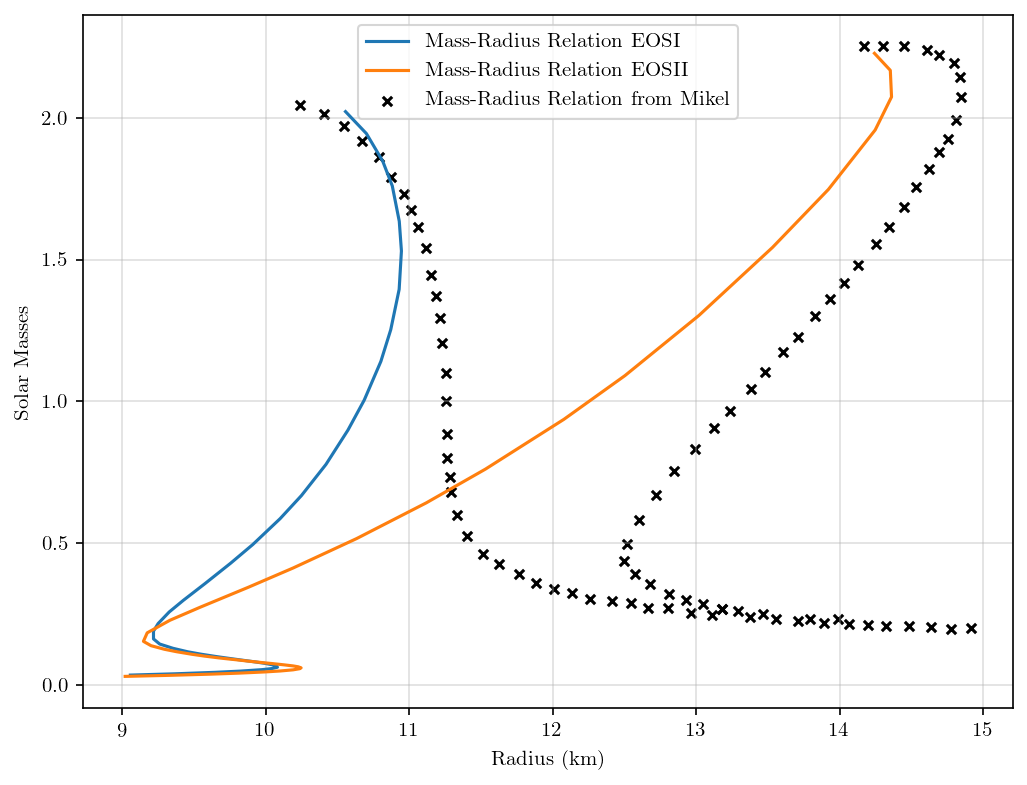

In [88]:
plt.figure(figsize=(8,6), dpi=150)

plt.plot(np.array(list_R_EOSI) * factor_R_to_km, np.array(list_M_EOSI) * factor_M_to_Solar, label='Mass-Radius Relation EOSI')
plt.plot(np.array(list_R_EOSII) * factor_R_to_km, np.array(list_M_EOSII)* factor_M_to_Solar, label='Mass-Radius Relation EOSII')

# open a file
data = pd.read_csv('../Data/Mass_radius_EOS1andEOS2.csv')
plt.scatter(data['x'], data[' y'], label='Mass-Radius Relation from Mikel', color='black', s=20, marker='x')
plt.xlabel('Radius (km)')
plt.ylabel('Solar Masses')
plt.grid()
plt.legend()
plt.show()

To be sure of the results I digitalized the EoS again

Because the shape is strange, there is a problem with the branches. I will change it manually

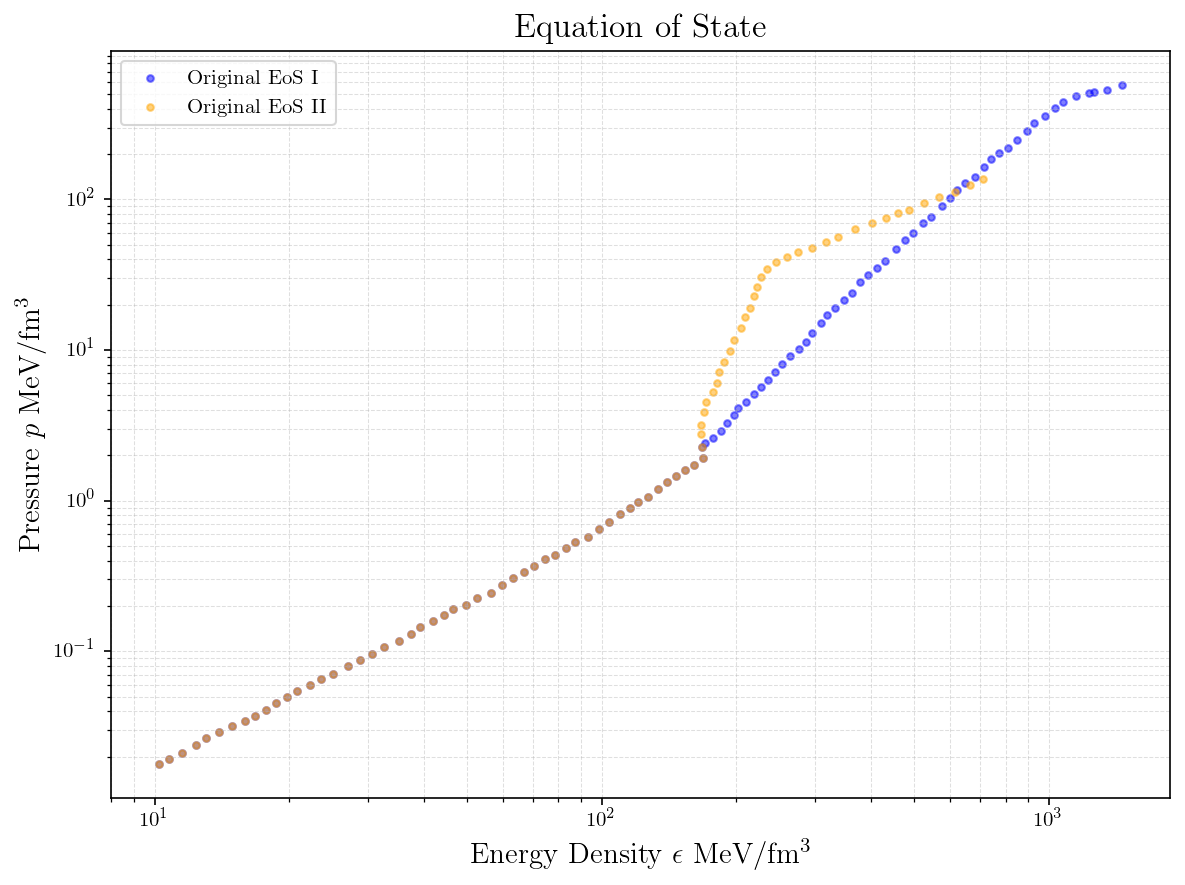

In [124]:
Complete_EOSII = pd.read_csv('../Data/CompleteEOSII.csv')
Complete_EOSII = Complete_EOSII.sort_values(by=' y').drop_duplicates(subset=[' y'])

grid_EOSII_e = Complete_EOSII['x'] * hc**3 / (4 * B) # Dimensionless energy density
grid_EOSII_p = Complete_EOSII[' y'] * hc**3 / (4 * B) # Dimensionless pressure


Upper_EOSI = pd.read_csv('../Data/UpperEOSI.csv')
Upper_EOSI = Upper_EOSI.sort_values(by=' y').drop_duplicates(subset=[' y'])
grid_EOSI_e = Upper_EOSI['x'] * hc**3 / (4 * B) # Dimensionless energy density
grid_EOSI_p = Upper_EOSI[' y'] * hc**3 / (4 * B) # Dimensionless pressure


#find the index of grid_EOSII_e that is closest to the minumm of grid_EOSI_e
min_EOSI_e = min(grid_EOSI_e)
index_closest = np.argmin(np.abs(grid_EOSII_e - min_EOSI_e)) - 3 # I subtract 3 to be sure to be on the left of the minimum, where the curves are closer

# 2. Create the new concatenated arrays
new_grid_e = np.concatenate((grid_EOSII_e[: index_closest], grid_EOSI_e))
new_grid_p = np.concatenate((grid_EOSII_p[: index_closest], grid_EOSI_p))

# 3. Now it is safe to overwrite your main variables
grid_EOSI_e = new_grid_e
grid_EOSI_p = new_grid_p

plt.figure(figsize=(8, 6))


plt.scatter(grid_EOSI_e * factor_P_to_Mevfm3  , grid_EOSI_p* factor_P_to_Mevfm3, label='Original EoS I', color='blue', s=10, alpha=0.5)
plt.scatter(grid_EOSII_e* factor_P_to_Mevfm3, grid_EOSII_p* factor_P_to_Mevfm3, label='Original EoS II', color='orange', s=10, alpha=0.5)

plt.xscale('log')
plt.yscale('log')


plt.xlabel(r'Energy Density $\epsilon$ MeV/fm$^3$', fontsize=14)
plt.ylabel(r'Pressure $p$  MeV/fm$^3$', fontsize=14)

plt.title('Equation of State', fontsize=16)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


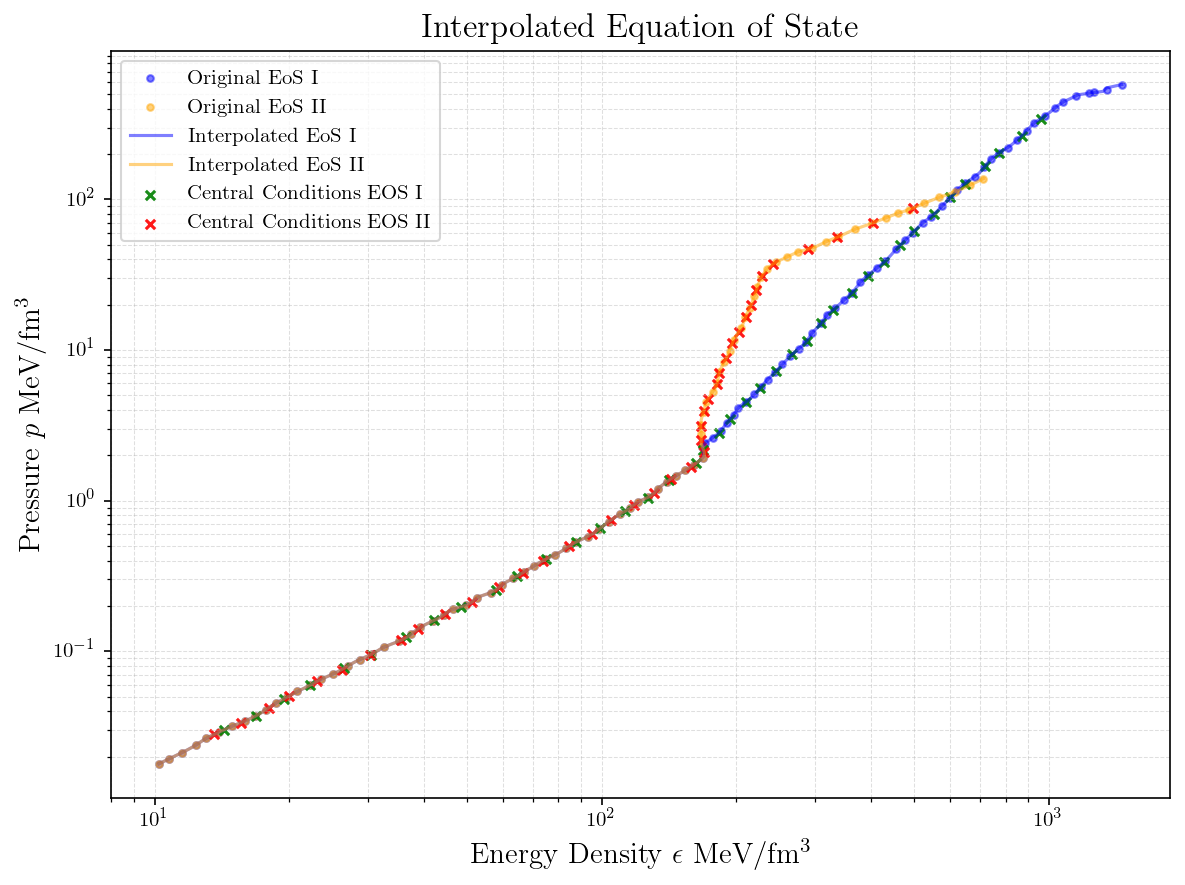

In [120]:


from scipy.interpolate import interp1d

interp_EOSI = interp1d(grid_EOSI_p, grid_EOSI_e, kind='cubic', fill_value="extrapolate")
interp_EOSII = interp1d(grid_EOSII_p, grid_EOSII_e, kind='cubic', fill_value="extrapolate")


new_pressures_EOSI = np.logspace(np.log10(min(grid_EOSI_p)), np.log10(max(grid_EOSI_p)), 200)
new_pressures_EOSII = np.logspace(np.log10(min(grid_EOSII_p)), np.log10(max(grid_EOSII_p)), 200)

new_energy_EOSI = interp_EOSI(new_pressures_EOSI)
new_energy_EOSII = interp_EOSII(new_pressures_EOSII)


# Create Initial conditions: 


# Create initial coditions for TOV loop

# Remove the extremums  5%
total_len_EOSI = len(new_pressures_EOSI)
offset_EOSI = int(total_len_EOSI * 0.05) 

total_len_EOSII = len(new_pressures_EOSII)
offset_EOSII = int(total_len_EOSII * 0.05) 


# Discard top 5% and bottom 5%)

trimmed_p_EOSI = new_pressures_EOSI[offset_EOSI:-offset_EOSI]
trimmed_e_I = new_energy_EOSI[offset_EOSI:-offset_EOSI]

trimmed_p_EOSII = new_pressures_EOSII[offset_EOSII:-offset_EOSII]
trimmed_e_II = new_energy_EOSII[offset_EOSII:-offset_EOSII]

# Pick 20% indices from this trimmed range
num_samples_EOSI = int(total_len_EOSI * 0.20)
indices_EOSI = np.linspace(0, len(trimmed_p_EOSI) - 1, num_samples_EOSI, dtype=int)

num_samples_EOSII = int(total_len_EOSII * 0.20)
indices_EOSII = np.linspace(0, len(trimmed_p_EOSII) - 1, num_samples_EOSII, dtype=int)

#  Final lists
list_p_central_conditions_EOSI = trimmed_p_EOSI[indices_EOSI]
list_p_central_conditions_EOSII = trimmed_p_EOSII[indices_EOSII]
list_e_central_conditions_EOSI = trimmed_e_I[indices_EOSI]
list_e_central_conditions_EOSII = trimmed_e_II[indices_EOSII]



plt.figure(figsize=(8, 6))


plt.scatter(grid_EOSI_e * factor_P_to_Mevfm3  , grid_EOSI_p* factor_P_to_Mevfm3, label='Original EoS I', color='blue', s=10, alpha=0.5)
plt.scatter(grid_EOSII_e* factor_P_to_Mevfm3, grid_EOSII_p* factor_P_to_Mevfm3, label='Original EoS II', color='orange', s=10, alpha=0.5)

plt.plot(new_energy_EOSI* factor_P_to_Mevfm3, new_pressures_EOSI* factor_P_to_Mevfm3, label='Interpolated EoS I', color='blue', linestyle='-', alpha=0.5)
plt.plot(new_energy_EOSII* factor_P_to_Mevfm3, new_pressures_EOSII* factor_P_to_Mevfm3, label='Interpolated EoS II', color='orange', linestyle='-', alpha=0.5)

plt.scatter(list_e_central_conditions_EOSI* factor_P_to_Mevfm3, list_p_central_conditions_EOSI* factor_P_to_Mevfm3, label='Central Conditions EOS I', color='green', s=20, marker='x', alpha=0.9)
plt.scatter(list_e_central_conditions_EOSII* factor_P_to_Mevfm3, list_p_central_conditions_EOSII* factor_P_to_Mevfm3, label='Central Conditions EOS II ', color='red', s=20, marker='x', alpha=0.9)

plt.xscale('log')
plt.yscale('log')


plt.xlabel(r'Energy Density $\epsilon$ MeV/fm$^3$', fontsize=14)
plt.ylabel(r'Pressure $p$  MeV/fm$^3$', fontsize=14)

plt.title('Interpolated Equation of State', fontsize=16)
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


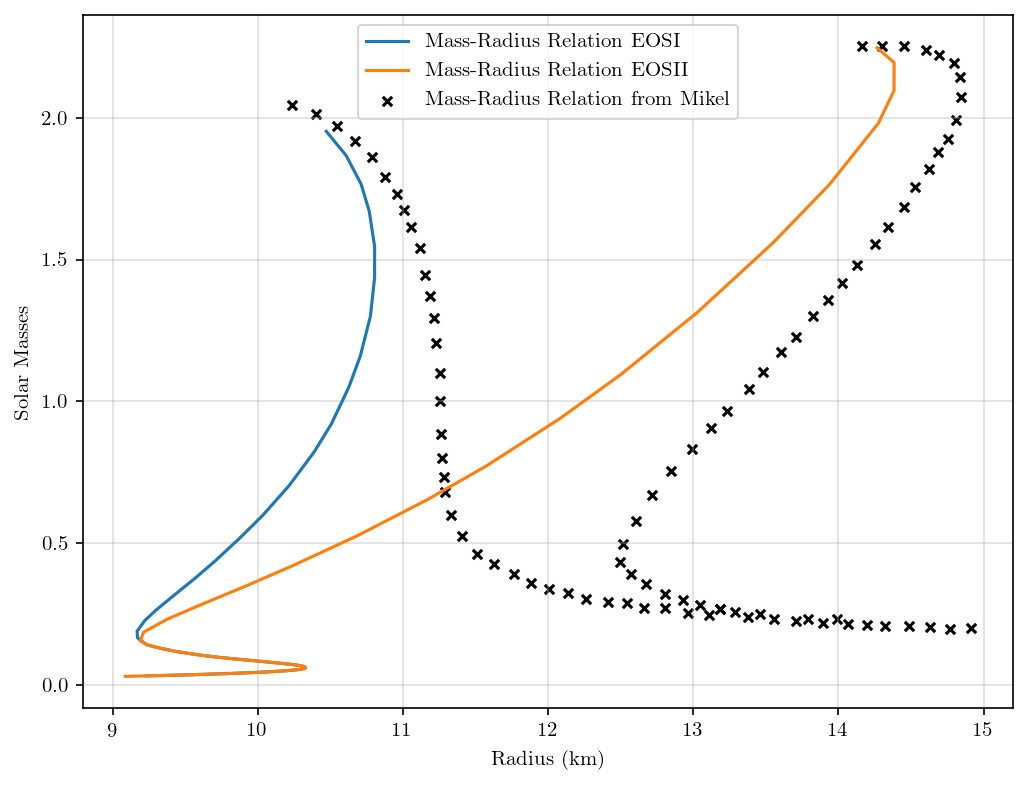

In [122]:
list_R_EOSI = []
list_M_EOSI = []
list_R_EOSII = []
list_M_EOSII = []


for p_central_EOSI, p_central_EOSII, e_central_EOSI, e_central_EOSII in zip(list_p_central_conditions_EOSI, list_p_central_conditions_EOSII, list_e_central_conditions_EOSI, list_e_central_conditions_EOSII):
    r0 = 1e-6
    central_mass_EOSI = (4/3) * np.pi * (r0**3) * e_central_EOSI
    x0_EOSI = [p_central_EOSI, central_mass_EOSI]

    R_surface_EOSI, M_surface_EOSI = solve_TOV(e_central_EOSI, x0_EOSI, new_pressures_EOSI, new_energy_EOSI)

    list_R_EOSI.append(R_surface_EOSI)
    list_M_EOSI.append(M_surface_EOSI)

    central_mass_EOSII = (4/3) * np.pi * (r0**3) * e_central_EOSII
    x0_EOSII = [p_central_EOSII, central_mass_EOSII]

    R_surface_EOSII, M_surface_EOSII = solve_TOV(e_central_EOSII, x0_EOSII,  new_pressures_EOSII,new_energy_EOSII)

    list_R_EOSII.append(R_surface_EOSII)
    list_M_EOSII.append(M_surface_EOSII)


plt.figure(figsize=(8,6), dpi=150)

plt.plot(np.array(list_R_EOSI) * factor_R_to_km, np.array(list_M_EOSI) * factor_M_to_Solar, label='Mass-Radius Relation EOSI')
plt.plot(np.array(list_R_EOSII) * factor_R_to_km, np.array(list_M_EOSII)* factor_M_to_Solar, label='Mass-Radius Relation EOSII')

# open a file
data = pd.read_csv('../Data/Mass_radius_EOS1andEOS2.csv')
plt.scatter(data['x'], data[' y'], label='Mass-Radius Relation from Mikel', color='black', s=20, marker='x')
plt.xlabel('Radius (km)')
plt.ylabel('Solar Masses')
plt.grid()
plt.legend()
plt.show()